In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoModel , AutoImageProcessor , AutoTokenizer 
from datasets import load_dataset , Dataset
from datasets import Image as dImage
from PIL import Image
import torch
from torch import nn
from sklearn.model_selection import train_test_split

import os
import pickle

torch.cuda.empty_cache()

# import os
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

2024-05-21 19:29:04.585208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 19:29:05.319458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setting all floats to FP16 (mixed-precision)

In [2]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA TITAN V, compute capability 7.0


2024-05-21 19:29:09.422824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 19:29:09.458330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 19:29:09.458523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [4]:
# SAMPLES = 100
# df_acc = pd.read_pickle("./vqa_v2_acc.pkl")
# df = df_acc[:SAMPLES]

SAMPLE_SET = "100k"
# SAMPLE_SET = "10k"

df = pd.read_pickle(f"vqa_v2_sampled_{SAMPLE_SET}_clipped.pkl")
SAMPLES = len(df)

print("Number of samples are : " , SAMPLES)

df.head()

Number of samples are :  143000


,question,question_type,question_id,image_id,answer_type,label
0,Are all people in the image facing the same di...,are,107156001,COCO_train2014_000000107156.jpg,yes/no,"{'ids': ['yes', '2'], 'weights': [0.9, 0.1]}"
1,Are people getting on and off the train?,are,285042000,COCO_train2014_000000285042.jpg,yes/no,"{'ids': ['no'], 'weights': [1.0]}"
2,Are any people in this picture?,are,506653001,COCO_train2014_000000506653.jpg,yes/no,"{'ids': ['yes'], 'weights': [1.0]}"
3,Are those pizza slices?,are,464340001,COCO_train2014_000000464340.jpg,yes/no,"{'ids': ['no'], 'weights': [1.0]}"
4,Are people on the ski lift?,are,490267000,COCO_train2014_000000490267.jpg,yes/no,"{'ids': ['yes'], 'weights': [1.0]}"


In [5]:
np.array(Image.open("./train2014_3d/" + df["image_id"][0])).shape

(426, 640, 3)

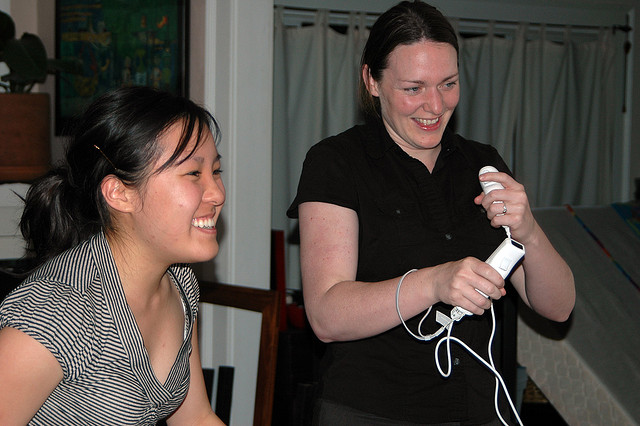

In [6]:
Image.open("./train2014_3d/" + df["image_id"][0])

Creating Labels

DO NOT CREATE LABELS AGAIN IF THE PICKLE FILE ALREADY EXISTS

Check for label2id_{SAMPLE_SET}_clipped.pkl and id2label_{SAMPLE_SET}_clipped.pkl

In [7]:
import itertools

if os.path.isfile(f"id2label_{SAMPLE_SET}_clipped.pkl") and os.path.isfile(f"label2id_{SAMPLE_SET}_clipped.pkl"):
    label2id = pickle.load(open(f"label2id_{SAMPLE_SET}_clipped.pkl" , "rb"))
    id2label = pickle.load(open(f"id2label_{SAMPLE_SET}_clipped.pkl" , "rb"))

else:
    labels = [item['ids'] for item in df['label'].to_list()]
    flattened_labels = list(itertools.chain(*labels))
    unique_labels = list(set(flattened_labels))

    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {idx: label for label, idx in label2id.items()} 
    
    with open(f"label2id_{SAMPLE_SET}_clipped.pkl" , "wb") as f:
        pickle.dump(label2id , f , pickle.HIGHEST_PROTOCOL)
    
    with open(f"id2label_{SAMPLE_SET}_clipped.pkl" , "wb") as f:
        pickle.dump(id2label , f , pickle.HIGHEST_PROTOCOL)

In [8]:
label2id

{'spinach': 0,
 'inside': 1,
 'stick': 2,
 'lemon': 3,
 'blue and white': 4,
 'olives': 5,
 'clay': 6,
 'tennis racquet': 7,
 'standing': 8,
 'tulips': 9,
 '32': 10,
 'beanie': 11,
 'christmas': 12,
 'work': 13,
 'dark brown': 14,
 'wine': 15,
 'cloth': 16,
 'green and blue': 17,
 'blue, white': 18,
 'orange and white': 19,
 'dark': 20,
 'shadow': 21,
 'living': 22,
 '21': 23,
 'field': 24,
 'phone': 25,
 'coke': 26,
 'tiles': 27,
 '36': 28,
 'scarf': 29,
 'too many to count': 30,
 '23': 31,
 'skateboarding': 32,
 'evening': 33,
 'boy': 34,
 'playing tennis': 35,
 'modern': 36,
 'trash can': 37,
 '2': 38,
 'north': 39,
 'uk': 40,
 'diamond': 41,
 'dirty': 42,
 'burgundy': 43,
 'right': 44,
 '17': 45,
 'rectangular': 46,
 'flying': 47,
 'autumn': 48,
 'string': 49,
 'hair': 50,
 'kites': 51,
 'weeds': 52,
 'khaki': 53,
 '5': 54,
 'to left': 55,
 'africa': 56,
 'posing': 57,
 'up': 58,
 'afternoon': 59,
 'hydrant': 60,
 'tile': 61,
 'on desk': 62,
 'black and gray': 63,
 'tree': 64,
 'pl

In [9]:
NUM_CLASSES = len(id2label)
print("Number of Classes : " , NUM_CLASSES)

Number of Classes :  997


Testing BERT and ViT

In [10]:
MAX_LEN = 40

In [11]:
DEVICE = "cuda"

vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
# model = AutoModel.from_pretrained("google/vit-base-patch16-224").to(DEVICE)
# vit_model = AutoModel.from_pretrained("google/vit-base-patch16-224")

/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
from transformers import BertTokenizer , BertModel

bert_processor = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### TensorFlow

Create ViT and BERT models

In [13]:
from transformers import TFAutoModelForSequenceClassification , TFAutoModel , TFAutoModelForImageClassification , TFBertModel
from tensorflow.keras.optimizers import Adam

vit_tf_model = TFAutoModel.from_pretrained("google/vit-base-patch16-224")
bert_tf_model = TFBertModel.from_pretrained('bert-base-uncased')


2024-05-21 19:29:24.983266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 19:29:24.983461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 19:29:24.983564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
class Dataset_Generator(tf.keras.utils.Sequence) :
    def __init__(self, image_filenames, questions , labels, batch_size) :
        self.image_filenames = image_filenames
        self.questions = questions
        self.labels = labels
        self.batch_size = batch_size


    def __len__(self) :
        return int(len(self.image_filenames) / self.batch_size)


    def __getitem__(self, idx) :
        batch_x_img = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_x_text = self.questions[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        batch_x_img = [Image.open(f"train2014_3d/{i}") for i in batch_x_img]
        
        img_feat = vit_processor(batch_x_img , return_tensors = "np")
        text_feat = bert_processor(batch_x_text , padding='max_length', max_length=MAX_LEN, truncation=True, return_tensors="np")
        
        labels = []
        for i in batch_y:
            r = [0 for i in id2label]
            for t , w in zip(i["ids"] , i["weights"]):
                r[label2id[t]] = w
            labels.append(r)
        
        # return x , y
        # return np.array([
        #         resize(imread('/content/all_images/' + str(file_name)), (80, 80, 3))
        #             for file_name in batch_x])/255.0, np.array(batch_y)
        # print(labels)
        return [img_feat["pixel_values"] , text_feat["input_ids"] , text_feat["attention_mask"]] , np.array(labels)

In [15]:
BATCH_SIZE = 16

validation_split = 0.3
# validation_split_len = int(validation_split * SAMPLES)

# df_sampled = df.sample(frac=1).reset_index(drop=True) #shuffle the dataset

# df_train = df_sampled[: -validation_split_len]
# df_test = df_sampled[-validation_split_len : - validation_split_len // 2]
# df_val = df_sampled[- validation_split_len // 2 : ]

X = df[["image_id" , "question"]]
Y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=validation_split, random_state=42)

validation_test_split = len(X_test) // 2

training_gen = Dataset_Generator(
    X_train["image_id"].to_list(), 
    X_train["question"].to_list(), 
    y_train.to_list(),
    BATCH_SIZE
)

validation_gen = Dataset_Generator(
    X_test["image_id"][:validation_test_split].to_list(), 
    X_test["question"][:validation_test_split].to_list(), 
    y_test[:validation_test_split].to_list(),
    BATCH_SIZE
)

test_gen = Dataset_Generator(
    X_test["image_id"][validation_test_split:].to_list(), 
    X_test["question"][validation_test_split:].to_list(), 
    y_test[validation_test_split:].to_list(),
    BATCH_SIZE
)

len(X_train) , len(X_test)

(100100, 42900)

Build our Custom Model

In [16]:
def build_model():
    vit_inputs = tf.keras.layers.Input(shape=(3, 224, 224))
    vit_tf_model.trainable = True
    x_vit = vit_tf_model(vit_inputs).pooler_output
    
    bert_input1 = tf.keras.layers.Input(shape=(MAX_LEN,) , dtype=tf.int32)
    bert_input2 = tf.keras.layers.Input(shape=(MAX_LEN,) , dtype=tf.int32)
    bert_tf_model.trainable = True
    x_bert = bert_tf_model(input_ids=bert_input1 , attention_mask=bert_input2).pooler_output
    
    # x = np.concatenate([x_vit , x_bert])
    out = tf.keras.layers.Concatenate(axis=1)([x_vit, x_bert])
    # x = x_bert
    
    dense_1 = tf.keras.layers.Dense(256 , input_shape=(768*2,) , activation='relu')
    out = dense_1(out)
    
    print("Datatypes being used--->")
    print(dense_1.dtype_policy)
    print('out.dtype: %s' % out.dtype.name)
    # 'kernel' is dense1's variable
    print('dense_1.kernel.dtype: %s' % dense_1.kernel.dtype.name)
    print("=" * 50)
    
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    # out = tf.keras.layers.Dense(512 , input_shape=(768*2,) , activation='relu')(out)
    # out = tf.keras.layers.Dropout(0.25)(out)
    # out = tf.keras.layers.Dense(256 , activation='relu')(out)
    # out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.Dense(64 , activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.Dense(NUM_CLASSES , activation='softmax')(out)
    
    # out = tf.keras.layers.Dense(NUM_CLASSES , input_shape=(768*2,) , activation='softmax')(out)
    
    model = tf.keras.models.Model(inputs=[vit_inputs , bert_input1 , bert_input2] , outputs=out)
    
    return model


modelx = build_model()
opt = tf.keras.optimizers.AdamW(3e-5 , 1e-2)
# opt = Adam(3e-5)
modelx.compile(optimizer= opt, loss="categorical_crossentropy", metrics=['accuracy'])
modelx.summary()

Datatypes being used--->
<Policy "mixed_float16">
out.dtype: float16
dense_1.kernel.dtype: float32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3, 224, 224)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 tf_vi_t_model (TFViTModel)  TFBaseModelOutputWithPooli   8638924   ['input_1[0][0]']         

In [17]:
# modelx.fit_generator(generator=training_gen,
#                     epochs = 20,
#                     validation_data=validation_gen
#                     )

history = modelx.fit(training_gen , epochs=20 , validation_data=validation_gen)


Epoch 1/20


2024-05-21 19:30:53.145861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-05-21 19:30:54.019984: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x39f7a8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 19:30:54.020010: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2024-05-21 19:30:54.023998: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-21 19:30:54.122922: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6256/6256 [==============================] - 1424s 213ms/step - loss: 4.2165 - accuracy: 0.3207 - val_loss: 2.8287 - val_accuracy: 0.4360
Epoch 2/20
6256/6256 [==============================] - 1294s 207ms/step - loss: 2.6793 - accuracy: 0.4512 - val_loss: 2.1175 - val_accuracy: 0.5034
Epoch 3/20
6256/6256 [==============================] - 1202s 192ms/step - loss: 2.1190 - accuracy: 0.5410 - val_loss: 1.7857 - val_accuracy: 0.5551
Epoch 4/20
6256/6256 [==============================] - 1203s 192ms/step - loss: 1.7748 - accuracy: 0.6201 - val_loss: 1.5948 - val_accuracy: 0.5997
Epoch 5/20
6256/6256 [==============================] - 1205s 193ms/step - loss: 1.5325 - accuracy: 0.6785 - val_loss: 1.4638 - val_accuracy: 0.6286
Epoch 6/20
6256/6256 [==============================] - 1187s 190ms/step - loss: 1.3509 - accuracy: 0.7228 - val_loss: 1.3572 - val_accuracy: 0.6481
Epoch 7/20
6256/6256 [==============================] - 1174s 188ms/step - loss: 1.2166 - accuracy: 0.7534 - val_loss

In [18]:
modelx.evaluate(test_gen)

1340/1340 [==============================] - 112s 84ms/step - loss: 1.1750 - accuracy: 0.7163


[1.174983263015747, 0.7163246273994446]

In [19]:
modelx.save(f"vqa_{SAMPLE_SET}_fp16_clipped.keras")

/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [20]:
modelx.save_weights(f"vqa_{SAMPLE_SET}_fp16_clipped.h5")

Inference

In [26]:
model_loaded = build_model()
model_loaded.compile(loss="categorical_crossentropy", metrics=['accuracy'])
model_loaded.load_weights(f"vqa_{SAMPLE_SET}_fp16_clipped.h5")

Datatypes being used--->
<Policy "mixed_float16">
out.dtype: float16
dense_1.kernel.dtype: float32


In [27]:
model_loaded.evaluate(test_gen)

1340/1340 [==============================] - 117s 83ms/step - loss: 1.1750 - accuracy: 0.7163


[1.174983263015747, 0.7163246273994446]

In [28]:
from sklearn.metrics import confusion_matrix

#Predict
y_prediction = model_loaded.predict(test_gen)
y_true = test_gen.labels

y_labels = []
for i in y_true:
    r = [0 for i in id2label]
    for t , w in zip(i["ids"] , i["weights"]):
        r[label2id[t]] = w
    y_labels.append(r)

1340/1340 [==============================] - 115s 82ms/step


In [29]:
y1 , y2 = np.rint(y_labels[:-10]).astype(np.int32) , np.rint(y_prediction).astype(np.int32)
y1 = y1.argmax(axis=1)
y2 = y2.argmax(axis=1)

y1.shape , y2.shape

((21440,), (21440,))

In [31]:
from sklearn.metrics import f1_score, recall_score, accuracy_score , precision_score

f1_score = f1_score(y1 , y2 , average='weighted')
recall_score = recall_score(y1 , y2 , average='weighted')
accuracy_score = accuracy_score(y1 , y2)
precision_score = precision_score(y1 , y2 , average='weighted')

print("F1 Score : " , f1_score)
print("Recall : " , recall_score)
print("Accuracy : " , accuracy_score)
print("Precision : " , precision_score)

F1 Score :  0.6951835154704581
Recall :  0.6961753731343283
Accuracy :  0.6961753731343283
Precision :  0.7093277175611818


/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test = df.iloc[0]
test_question = test["question"]
# test_question = "gow many animals are there"
test_image = Image.open("train2014_3d/" + test["image_id"])

display(test_image)

test_text_feat = bert_processor([test_question] , padding='max_length', max_length=MAX_LEN, truncation=True, return_tensors="np")
test_image_feat = vit_processor([test_image] , return_tensors="np")["pixel_values"]


print("Question : " , test_question)
ans = model_loaded.predict([test_image_feat , test_text_feat["input_ids"] , test_text_feat["attention_mask"]])
ans = np.argmax(ans)
ans = id2label[ans]
print("Answer : " , ans)
